<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/085_NeRF_Neural_Radiance_Fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧊 NeRF: Świat zamknięty w sieci neuronowej

NeRF reprezentuje scenę 3D jako **ciągłą funkcję**.
To mała sieć MLP, która dla każdego punktu w przestrzeni ($x, y, z$) zwraca jego gęstość ($\sigma$) i kolor ($RGB$).

**Algorytm Renderowania (Ray Marching):**
1.  Wypuszczamy promień z oka kamery przez piksel.
2.  Próbkujemy punkty wzdłuż promienia (co kawałek).
3.  Dla każdego punktu pytamy sieć: *"Co tu jest?"*.
4.  Sumujemy kolory, ważąc je gęstością (jeśli trafiliśmy na ścianę, to co jest za nią, jest niewidoczne).

Kluczowy trik: **Positional Encoding**. Zwykła sieć widzi świat jako rozmytą plamę. Musimy zamienić współrzędne $(x,y,z)$ na wysokie częstotliwości (sinusy/cosinusy), żeby zobaczyć detale.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
L_EMBED = 10 # Liczba częstotliwości w Positional Encoding (dla pozycji)
L_DIR = 4    # Liczba częstotliwości dla kierunku

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Krok 1: Positional Encoding (Fourier Features)

To podobny mechanizm jak w Transformerze (Notatnik 56), ale tutaj służy do czegoś innego.
Sieci neuronowe mają tendencję do uczenia się tylko "niskich częstotliwości" (gładkich kolorów).
Żeby nauczyć się ostrych krawędzi i tekstur, musimy "rozdmuchać" wejście $(x,y,z)$ do wielowymiarowego wektora sinusów.

$$ \gamma(p) = (\sin(2^0 \pi p), \cos(2^0 \pi p), ..., \sin(2^{L-1} \pi p), \cos(2^{L-1} \pi p)) $$

In [2]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_input, n_freqs):
        super().__init__()
        self.d_input = d_input
        self.n_freqs = n_freqs
        # Częstotliwości: 2^0, 2^1, ... 2^(N-1)
        self.freq_bands = 2.**torch.linspace(0., n_freqs - 1, n_freqs)

    def forward(self, x):
        # x: [Batch, d_input]
        # Dla każdego kanału wejściowego tworzymy sin i cos dla każdej częstotliwości
        embed = [x]
        for freq in self.freq_bands.to(x.device):
            embed.append(torch.sin(x * freq * np.pi))
            embed.append(torch.cos(x * freq * np.pi))
        
        # Sklejamy wszystko w długi wektor
        return torch.cat(embed, dim=-1)

# Test
encoder = PositionalEncoder(d_input=3, n_freqs=L_EMBED) # Wejście (x,y,z)
dummy_pt = torch.tensor([[0.5, 0.5, 0.5]])
out = encoder(dummy_pt)
print(f"Wejście (x,y,z): {dummy_pt.shape}")
print(f"Wyjście (Embedded): {out.shape} -> 3 + 3 * 2 * 10 = 63 wymiary")

Wejście (x,y,z): torch.Size([1, 3])
Wyjście (Embedded): torch.Size([1, 63]) -> 3 + 3 * 2 * 10 = 63 wymiary


## Krok 2: Model NeRF (MLP)

Sieć jest prosta, ale głęboka (zazwyczaj 8 warstw).
1.  Bierze zakodowaną pozycję ($x,y,z$).
2.  Przetwarza.
3.  Wypluwa **Gęstość ($\sigma$)** (czy to ciało stałe?).
4.  Dokleja zakodowany **Kierunek patrzenia**.
5.  Wypluwa **Kolor ($RGB$)**.

Dlaczego kierunek doklejamy na końcu?
Bo gęstość (kształt obiektu) jest stała, ale kolor zależy od kąta patrzenia (odblaski, lustra)!

In [3]:
class NeRF(nn.Module):
    def __init__(self, d_input=3, d_input_dir=3, hidden_dim=256):
        super().__init__()
        
        # Enkodery
        self.embed_pos = PositionalEncoder(d_input, L_EMBED)
        self.embed_dir = PositionalEncoder(d_input_dir, L_DIR)
        
        # Wymiary po enkodowaniu
        in_dim_pos = d_input + d_input * 2 * L_EMBED
        in_dim_dir = d_input_dir + d_input_dir * 2 * L_DIR
        
        # Sieć Główna (Gęstość)
        self.block1 = nn.Sequential(
            nn.Linear(in_dim_pos, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        )
        
        # Wyjście Gęstości (Sigma) + Cechy
        self.sigma_layer = nn.Linear(hidden_dim, 1 + hidden_dim) # 1 sigma + wektor cech
        
        # Sieć Koloru (Zależy od kierunku!)
        self.rgb_layer = nn.Sequential(
            nn.Linear(hidden_dim + in_dim_dir, hidden_dim // 2), nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3), # RGB
            nn.Sigmoid() # Kolor 0-1
        )

    def forward(self, x, d):
        # x: Pozycja, d: Kierunek
        x_emb = self.embed_pos(x)
        d_emb = self.embed_dir(d)
        
        # Liczymy geometrię
        h = self.block1(x_emb)
        sigma_and_feat = self.sigma_layer(h)
        
        # Rozdzielamy gęstość i cechy
        sigma = F.relu(sigma_and_feat[:, :1]) # Gęstość musi być >= 0
        features = sigma_and_feat[:, 1:]
        
        # Doklejamy kierunek i liczymy kolor
        h_color = torch.cat([features, d_emb], dim=-1)
        rgb = self.rgb_layer(h_color)
        
        return rgb, sigma

model = NeRF().to(DEVICE)
print("Model NeRF gotowy.")

Model NeRF gotowy.


## Krok 3: Wolumetryczne Renderowanie (Fizyka)

Mamy model, który dla punktu w kosmosie zwraca kolor i gęstość.
Teraz musimy "zrobić zdjęcie".

Dla każdego piksela strzelamy promieniem. Na promieniu wybieramy np. 64 punkty.
Sumujemy ich kolory, ale uwaga: **punkty bliżej zasłaniają te dalej**.

Wzór dyskretny:
$$ C = \sum T_i \cdot \alpha_i \cdot c_i $$
*   $\alpha_i = 1 - e^{-\sigma_i \delta_i}$: Nieprzezroczystość punktu.
*   $T_i$: Transmitancja (ile światła dotarło do tego punktu, nie będąc zablokowanym wcześniej).

In [8]:
# Wymuszamy losowe, silne wagi, żeby zobaczyć szum
def init_weights_crazy(m):
    if isinstance(m, nn.Linear):
        # Losujemy wagi z dużą siłą (odchylenie 1.0 zamiast 0.02)
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.5)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0.1)

# Aplikujemy to do modelu
model.apply(init_weights_crazy)

print("Model 'potrząśnięty'. Teraz powinieneś widzieć chaos.")

Model 'potrząśnięty'. Teraz powinieneś widzieć chaos.


In [9]:
def render_rays(model, ray_origins, ray_directions, near=0., far=1., n_samples=32):
    # ray_origins: [Batch, 3]
    # ray_directions: [Batch, 3]
    
    # 1. Próbkowanie punktów wzdłuż promienia
    # Tworzymy 't' od near do far
    z_vals = torch.linspace(near, far, n_samples).to(DEVICE)
    
    # --- POPRAWKA ---
    # Punkty w przestrzeni 3D: P = Origin + t * Direction
    # ray_origins: [Batch, 1, 3]
    # ray_directions: [Batch, 1, 3]
    # z_vals: [1, Samples, 1] (Używamy .view, aby wymusić ten kształt)
    points = ray_origins.unsqueeze(1) + ray_directions.unsqueeze(1) * z_vals.view(1, -1, 1)
    
    # Spłaszczamy do batcha, żeby wrzucić do sieci
    flat_points = points.reshape(-1, 3)
    # Kierunki są stałe dla całego promienia, ale musimy je powielić dla każdego punktu
    flat_dirs = ray_directions.unsqueeze(1).expand(-1, n_samples, -1).reshape(-1, 3)
    
    # 2. Pytamy NeRF
    rgb, sigma = model(flat_points, flat_dirs)
    
    # Przywracamy kształt [Batch, Samples]
    rgb = rgb.reshape(-1, n_samples, 3)
    sigma = sigma.reshape(-1, n_samples)
    
    # 3. Fizyka Renderowania (Volumetric Rendering)
    # Odległość między próbkami (delta)
    dists = z_vals[1:] - z_vals[:-1]
    dists = torch.cat([dists, torch.tensor([1e10]).to(DEVICE)]) # Ostatni dystans nieskończony
    
    # Alpha (Nieprzezroczystość w punkcie) = 1 - exp(-sigma * dist)
    alpha = 1.0 - torch.exp(-sigma * dists)
    
    # Transmitancja (Ile światła przeszło przez poprzednie punkty?)
    # Cumprod(1 - alpha) z przesunięciem (pierwszy punkt widzi 100%)
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)).to(DEVICE), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    
    # Finalny kolor piksela = Suma ważona kolorów punktów
    pixel_color = torch.sum(weights.unsqueeze(-1) * rgb, dim=1)
    
    # Depth map (mapa głębokości) - średnia ważona odległości
    depth_map = torch.sum(weights * z_vals, dim=1)
    
    return pixel_color, depth_map

print("Silnik renderujący gotowy (Poprawiony).")

Silnik renderujący gotowy (Poprawiony).


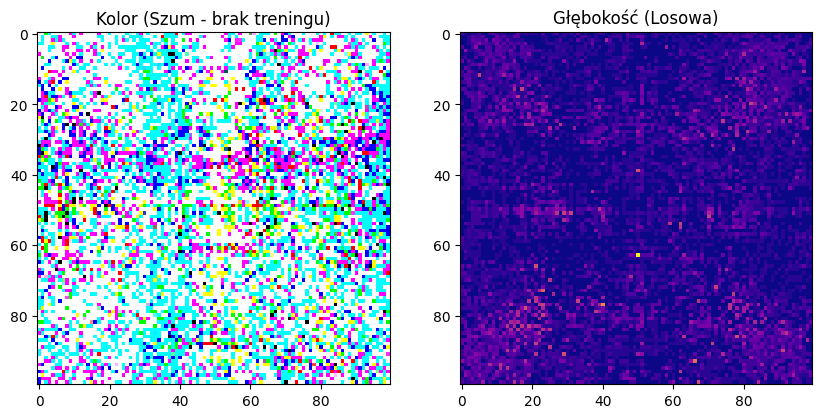

In [10]:
# TEST WIZUALNY (Przed treningiem)
# Tworzymy "kamerę" i strzelamy promieniami

H, W = 100, 100 # Rozdzielczość próbna
ray_origins = torch.zeros((H*W, 3)).to(DEVICE) # Kamera w (0,0,0)
ray_origins[:, 2] = -2.0 # Cofamy kamerę

# Kierunki promieni (uproszczone: strzelamy w prostokąt przed nami)
x = torch.linspace(-1, 1, W)
y = torch.linspace(-1, 1, H)
grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
ray_dirs = torch.stack([grid_x, grid_y, torch.ones_like(grid_x)], dim=-1).reshape(-1, 3).to(DEVICE)
ray_dirs = ray_dirs / torch.norm(ray_dirs, dim=-1, keepdim=True) # Normalizacja

# Renderujemy! (To potrwa chwilę, bo liczymy 10000 promieni x 32 punkty)
with torch.no_grad():
    colors, depths = render_rays(model, ray_origins, ray_dirs, near=1.0, far=3.0)

# Wyświetlamy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(colors.cpu().reshape(H, W, 3))
plt.title("Kolor (Szum - brak treningu)")

plt.subplot(1, 2, 2)
plt.imshow(depths.cpu().reshape(H, W), cmap='plasma')
plt.title("Głębokość (Losowa)")
plt.show()

## 🧠 Podsumowanie: Długi Trening

To, co widzisz (kolorowy szum), to **niezainicjowany mózg**.
W prawdziwym NeRF-ie teraz następuje faza treningu:
1.  Bierzemy prawdziwe zdjęcia obiektu (np. koparki Lego).
2.  Dla każdego piksela zdjęcia porównujemy `pixel_color` (z naszego modelu) z prawdą.
3.  Robimy Backpropagation przez... **promienie świetlne**! (To możliwe dzięki Autograd).

Sieć zmienia swoje wagi tak, żeby gęstość ($\sigma$) pojawiała się tam, gdzie jest obiekt, a znikała tam, gdzie jest powietrze. W ten sposób sieć "rzeźbi" obiekt w 3D.